# Chess Board Position Recogniser

## Setup

### Libraries

In [8]:
import pathlib
import sys

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from PIL import Image

import chess

import wandb


# Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet152

from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large


# Utils
sys.path.append('../utils')
from dataset_loader import populate_test_folder, load_dataset, load_train_valid_test_dataset
from visualisation import display_cropped_chess_board
from model import test_model


In [9]:
tf.__version__

'2.10.0'

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Constants

In [12]:
DATASET_DIR = pathlib.Path.cwd().parent / "data"

PIECE_LABELS = ['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']
NUM_CLASSES = len(PIECE_LABELS)

## Dataset

### Fetch Dataset From W&B

In [14]:
run = wandb.init(project="deepconvchess")

dataset_artifact = run.use_artifact('deepconvchess-dataset:latest')
dataset_artifact.download(root=str(DATASET_DIR))

populate_test_folder(DATASET_DIR)

wandb: Downloading large artifact deepconvchess-dataset:latest, 198.50MB. 1075 files... 
wandb:   1075 of 1075 files downloaded.  
Done. 0:0:1.3


### Load X and Y Dataset

Load images from real/ and render/ as train/validation split and test/ as test dataset

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = load_train_valid_test_dataset(DATASET_DIR)

Processing render/r1bq1rk1_pp4pp_5b2_2pp4_8_P1PQ2N1_1P3PPP_R1B2RK1 b - - 0 15.jpeg
Processing render/r1bq1rk1_pp4pp_5b2_2ppn3_8_P1PB2N1_1P3PPP_R1BQ1RK1 b - - 1 14.jpeg
Processing render/r1bq1rk1_pp4pp_5b2_2ppn3_8_P1PB2N1_1P3PPP_R1BQK2R w KQ - 0 14.jpeg
Processing render/r1bq1rk1_pppnppbp_3p1np1_8_2PP4_2N2NP1_PP2PPBP_R1BQ1RK1 b - - 4 7.jpeg
Processing render/r1bq1rk1_pppnppbp_3p1np1_8_2PP4_2N2NP1_PP2PPBP_R1BQK2R w KQ - 3 7.jpeg
Processing render/r1bqk1nr_1p2ppbp_p1np2p1_2p5_2P1P3_2NP1NP1_PP3PBP_R1BQK2R b KQkq - 1 7.jpeg
Processing render/r1bqk1nr_1p2ppbp_p1np2p1_2p5_2P1P3_3P1NP1_PP3PBP_RNBQK2R w KQkq - 0 7.jpeg
Processing render/r1bqk1nr_pp1pppbp_2n3p1_2p5_4P3_3P1NP1_PPP2PBP_RNBQK2R b KQkq - 0 5.jpeg
Processing render/r1bqk1nr_pp1pppbp_2n3p1_2p5_8_3P1NP1_PPP1PPBP_RNBQK2R w KQkq - 2 5.jpeg
Processing render/r1bqk1nr_pp2ppbp_2np2p1_2p5_2P1P3_3P1NP1_PP3PBP_RNBQK2R b KQkq - 0 6.jpeg
Processing render/r1bqk1nr_pp2ppbp_2np2p1_2p5_4P3_3P1NP1_PPP2PBP_RNBQK2R w KQkq - 0 6.jpeg
Processing render/

In [16]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))
print(" ")

total_images = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

print("Train Split: {:.2%}".format(X_train.shape[0] / total_images))
print("Validation Split: {:.2%}".format(X_val.shape[0] / total_images))
print("Test Split: {:.2%}".format(X_test.shape[0] / total_images))

X_train shape: (17868, 160, 160, 3)
y_train shape: (17868,)
X_val shape: (4468, 160, 160, 3)
y_val shape: (4468,)
X_test shape: (1664, 160, 160, 3)
y_test shape: (1664,)
 
Train Split: 74.45%
Validation Split: 18.62%
Test Split: 6.93%


### Display Example Cropped Board

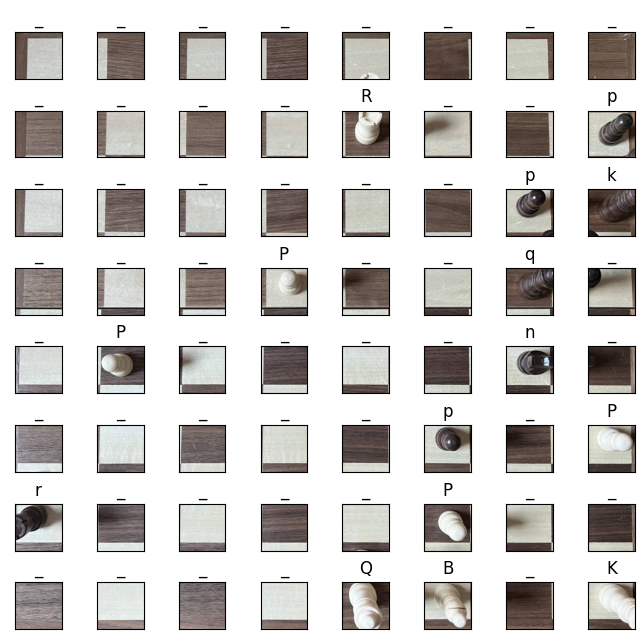

In [17]:
display_cropped_chess_board(X_test[0:64], y_test[0:64])

### Encode Labels

In [18]:
label_encoder = LabelEncoder()
label_encoder.fit(PIECE_LABELS)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

## Models

### ResNet

#### ResNet-50

In [19]:
model = test_model(ResNet50, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
559/559 [==============================] - 26s 41ms/step - loss: 0.1077 - accuracy: 0.9727 - val_loss: 0.0338 - val_accuracy: 0.9890
Epoch 2/10
559/559 [==============================] - 21s 38ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.0130 - val_accuracy: 0.9953
Epoch 3/10
559/559 [==============================] - 21s 38ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0117 - val_accuracy: 0.9969
Epoch 4/10
559/559 [==============================] - 22s 39ms/step - loss: 0.0039 - accuracy: 0.9994 - val_loss: 0.0357 - val_accuracy: 0.9931
Epoch 5/10
559/559 [==============================] - 22s 38ms/step - loss: 0.0176 - accuracy: 0.9959 - val_loss: 0.0214 - val_accuracy: 0.9942
Epoch 6/10
52/52 [==============================] - 2s 29ms/step


accuracy,▁███▇▇
epochs,▁
f1,▁
loss,█▁▁▁▂▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
total_params,▁
val_accuracy,▃▇█▆▆▁
val_loss,▄▁▁▄▂█


#### ResNet-152

In [20]:
test_model(ResNet152, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
559/559 [==============================] - 62s 100ms/step - loss: 0.1126 - accuracy: 0.9724 - val_loss: 0.0261 - val_accuracy: 0.9926
Epoch 2/10
559/559 [==============================] - 53s 95ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0234 - val_accuracy: 0.9935
Epoch 3/10
559/559 [==============================] - 52s 94ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0151 - val_accuracy: 0.9964
Epoch 4/10
559/559 [==============================] - 51s 91ms/step - loss: 6.2663e-04 - accuracy: 0.9998 - val_loss: 0.0162 - val_accuracy: 0.9962
Epoch 5/10
559/559 [==============================] - 51s 91ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0193 - val_accuracy: 0.9964
Epoch 6/10
559/559 [==============================] - 50s 90ms/step - loss: 6.5917e-04 - accuracy: 0.9999 - val_loss: 0.0156 - val_accuracy: 0.9975
Epoch 7/10
559/559 [==============================] - 51s 90ms/step - loss: 5.7720e-05 - accuracy: 1.0000 - val_loss: 0.0145 - 

accuracy,▁▇████████
epochs,▁
f1,▁
loss,█▁▁▁▁▁▁▁▁▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
total_params,▁
val_accuracy,▁▂▆▆▆█████
val_loss,█▇▂▃▄▂▂▁▁▁


### DenseNet

#### DenseNet-121

In [21]:
test_model(DenseNet121, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
559/559 [==============================] - 32s 50ms/step - loss: 0.7248 - accuracy: 0.8537 - val_loss: 0.2832 - val_accuracy: 0.9333
Epoch 2/10
559/559 [==============================] - 26s 47ms/step - loss: 0.2083 - accuracy: 0.9469 - val_loss: 0.1205 - val_accuracy: 0.9711
Epoch 3/10
559/559 [==============================] - 28s 50ms/step - loss: 0.1268 - accuracy: 0.9657 - val_loss: 0.1805 - val_accuracy: 0.9653
Epoch 4/10
559/559 [==============================] - 28s 50ms/step - loss: 0.1225 - accuracy: 0.9696 - val_loss: 0.1990 - val_accuracy: 0.9501
Epoch 5/10
52/52 [==============================] - 3s 41ms/step


accuracy,▁▆▇██
epochs,▁
f1,▁
loss,█▂▁▁▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
total_params,▁
val_accuracy,▁█▇▄▃
val_loss,▆▁▃▄█


### MobileNet

#### MobileNetV1

In [22]:
test_model(MobileNet, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
559/559 [==============================] - 11s 17ms/step - loss: 0.4574 - accuracy: 0.8697 - val_loss: 0.2215 - val_accuracy: 0.9344
Epoch 2/10
559/559 [==============================] - 9s 16ms/step - loss: 0.1545 - accuracy: 0.9564 - val_loss: 0.1581 - val_accuracy: 0.9499
Epoch 3/10
559/559 [==============================] - 9s 16ms/step - loss: 0.0958 - accuracy: 0.9748 - val_loss: 0.1163 - val_accuracy: 0.9624
Epoch 4/10
559/559 [==============================] - 9s 16ms/step - loss: 0.0647 - accuracy: 0.9856 - val_loss: 0.1041 - val_accuracy: 0.9651
Epoch 5/10
559/559 [==============================] - 9s 15ms/step - loss: 0.0475 - accuracy: 0.9903 - val_loss: 0.0954 - val_accuracy: 0.9711
Epoch 6/10
559/559 [==============================] - 9s 15ms/step - loss: 0.0369 - accuracy: 0.9928 - val_loss: 0.0838 - val_accuracy: 0.9731
Epoch 7/10
559/559 [==============================] - 9s 15ms/step - loss: 0.0275 - accuracy: 0.9957 - val_loss: 0.0883 - val_accuracy: 0.968

accuracy,▁▆▇▇██████
epochs,▁
f1,▁
loss,█▃▂▂▂▁▁▁▁▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
total_params,▁
val_accuracy,▁▄▆▆▇▇▆███
val_loss,█▅▃▃▂▂▂▁▁▁


#### MobileNetV2

In [23]:
test_model(MobileNetV2, X_train, y_train, X_val, y_val, X_test, y_test)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

#### MobileNetV3

##### MobileNetV3-Small

In [ ]:
test_model(MobileNetV3Small, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
175/175 [==============================] - 6s 19ms/step - loss: 0.4240 - accuracy: 0.8873 - val_loss: 0.0842 - val_accuracy: 0.9799
Epoch 2/10
175/175 [==============================] - 3s 15ms/step - loss: 0.0241 - accuracy: 0.9959 - val_loss: 0.0577 - val_accuracy: 0.9857
Epoch 3/10
175/175 [==============================] - 3s 15ms/step - loss: 0.0092 - accuracy: 0.9995 - val_loss: 0.0459 - val_accuracy: 0.9900
Epoch 4/10
175/175 [==============================] - 3s 15ms/step - loss: 0.0050 - accuracy: 0.9998 - val_loss: 0.0433 - val_accuracy: 0.9907
Epoch 5/10
175/175 [==============================] - 3s 15ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9914
Epoch 6/10
175/175 [==============================] - 3s 16ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 0.9914
Epoch 7/10
175/175 [==============================] - 3s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0370 - val_accuracy: 0.9914

accuracy,▁███████
epochs,▁
f1,▁
loss,█▁▁▁▁▁▁▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
total_params,▁
val_accuracy,▁▅▇█████
val_loss,█▄▂▂▂▁▁▁


##### MobileNetV3-Large

In [ ]:
test_model(MobileNetV3Large, X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
175/175 [==============================] - 6s 24ms/step - loss: 0.3051 - accuracy: 0.9224 - val_loss: 0.0565 - val_accuracy: 0.9835
Epoch 2/10
175/175 [==============================] - 3s 19ms/step - loss: 0.0105 - accuracy: 0.9987 - val_loss: 0.0413 - val_accuracy: 0.9900
Epoch 3/10
175/175 [==============================] - 3s 19ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.0323 - val_accuracy: 0.9950
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9950
Epoch 5/10
175/175 [==============================] - 3s 19ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.9957
Epoch 6/10
175/175 [==============================] - 3s 19ms/step - loss: 8.2883e-04 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9957
Epoch 7/10
175/175 [==============================] - 3s 19ms/step - loss: 6.4583e-04 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy

accuracy,▁█████████
epochs,▁
f1,▁
loss,█▁▁▁▁▁▁▁▁▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
total_params,▁
val_accuracy,▁▄▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁


## Evaluation

### Validation Set

In [12]:
loss, accuracy = model.evaluate(X_val, y_val)

print('Val loss:', loss)
print('Val accuracy:', accuracy)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

### Test Set

In [13]:
len(X_test)

1664

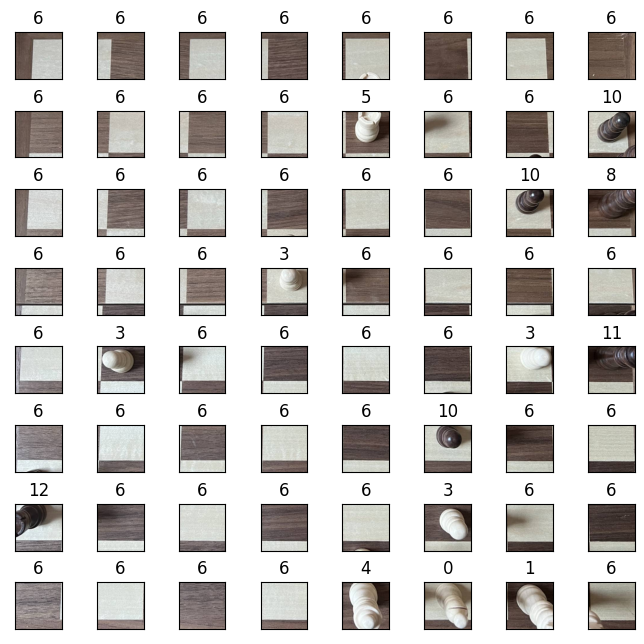

In [14]:
display_cropped_chess_board(X_test[0:64], y_test[0:64])

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

52/52 [==============================] - 2s 30ms/step - loss: 0.1672 - accuracy: 0.9802
Test loss: 0.16724222898483276
Test accuracy: 0.9801682829856873


In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

52/52 [==============================] - 2s 31ms/step


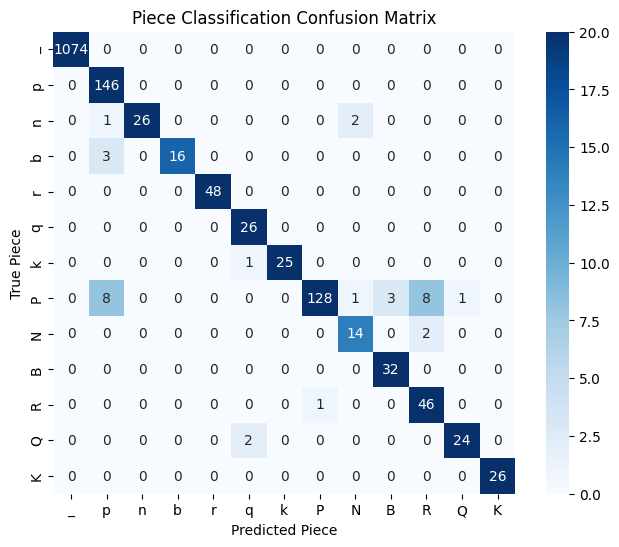

In [19]:
conf_matrix = confusion_matrix(
    y_true=label_encoder.inverse_transform(y_test), 
    y_pred=label_encoder.inverse_transform(y_pred), 
    labels=PIECE_LABELS
)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=PIECE_LABELS, yticklabels=PIECE_LABELS, vmax=20)
plt.xlabel('Predicted Piece')
plt.ylabel('True Piece')
plt.title('Piece Classification Confusion Matrix')
plt.show()

In [24]:
fen = "r5k1_3n1r1p_2RQ2p1_3P2q1_1P6_5p1P_5P2_2R2B1K b - - 1 29.jpg".split(".")[0]
fen = fen.replace("_", "/")
board = chess.Board(fen)

img = Image.open(DATASET_DIR / "test" / "r5k1_3n1r1p_2RQ2p1_3P2q1_1P6_5p1P_5P2_2R2B1K b - - 1 29.jpg")
IMG_WIDTH, IMG_HEIGHT = img.size

X_unseen = []

# Crop each image into 64 sections, one for each tile on the board
for i in range(8):
    for j in range(8):
        crop_x = j * IMG_WIDTH // 8
        crop_y = i * IMG_HEIGHT // 8
        img_crop = img.crop((crop_x, crop_y, crop_x + IMG_WIDTH // 8, crop_y + IMG_HEIGHT // 8))

        piece = board.piece_at(((7 - i) * 8) + j)
        if piece is not None:
            piece = piece.symbol()
        else:
            piece = '_'

        X_unseen.append(np.array(img_crop))

In [25]:
len(X_unseen)

64

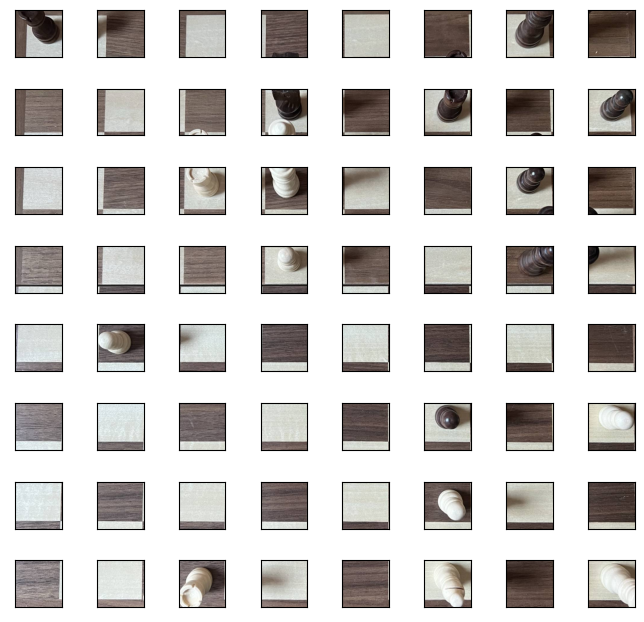

In [26]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X_unseen[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

In [27]:
y_pred = []
for i in range(0, 64):
    image = np.expand_dims(X_unseen[i], axis=0)

    prediction = model.predict(image)
    prediction = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

    y_pred.append(prediction[0])

1/1 [==============================] - 0s 20ms/step


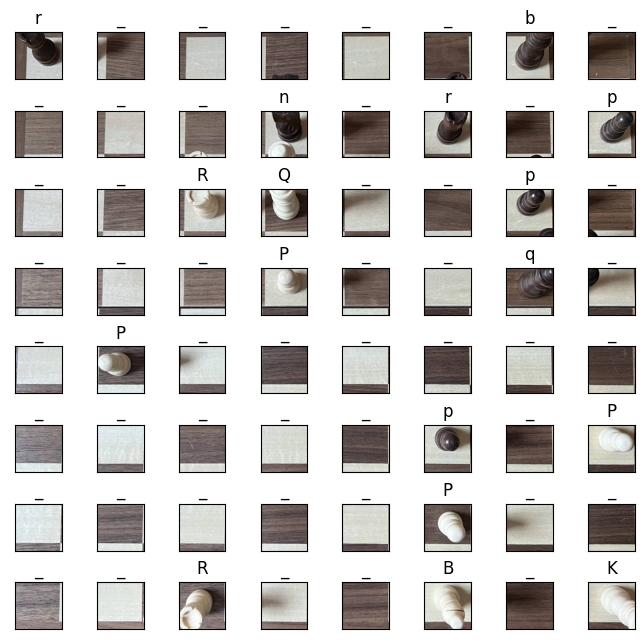

In [28]:
display_cropped_chess_board(X_unseen, y_pred)

In [ ]:
for i in range(0, len(predicted_y)):
    if predicted_y[i] != '_':
        piece = chess.Piece.from_symbol(predicted_y[i])
        square = chess.SQUARES[63 - i]
        board.set_piece_at(square, piece)

predicted_fen = board.fen()
predicted_fen

'rkrqqrkr/pbpnrpbp/pp1pp1pq/3bR3/2RBPR2/Bp1pQ1kP/PKp2PBk/1KK2RK1 b - - 0 18'

NameError: name 'predicted_fen' is not defined

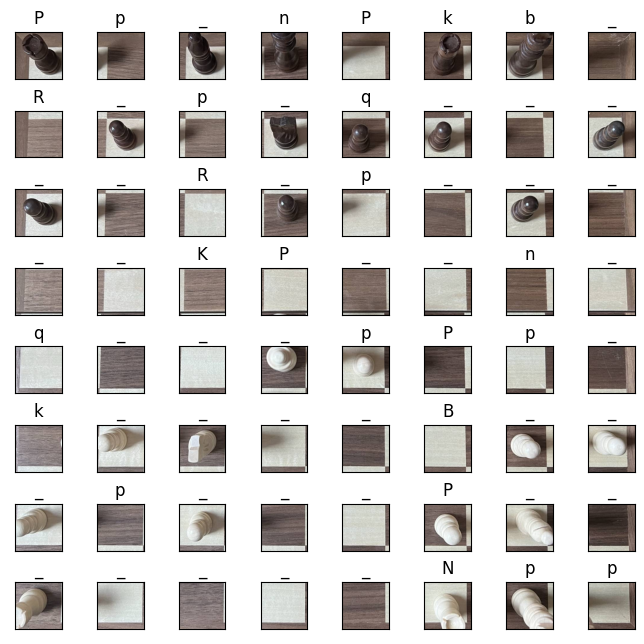

In [34]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X_test[i])
    plt.title(predicted_y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

fig.suptitle("True FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR\nPredicted FEN: %s" % predicted_fen.split(" ")[0])
fig.savefig('predicted_board', dpi=300, bbox_inches='tight')